In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.chdir("/home/zha0yuewarwick/projects/PhEE/eeqa")
import torch
import argparse 
import numpy as np
import json
import random
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE, WEIGHTS_NAME, CONFIG_NAME
from pytorch_pretrained_bert.modeling import BertForQuestionAnswering, BertForQuestionAnswering_withIfTriggerEmbedding
from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear
from pytorch_pretrained_bert.tokenization import BertTokenizer
# from run_args_qa import AceExample, InputFeatures, read_query_templates, read_ace_examples,  make_predictions, convert_examples_to_features, evaluate
from run_args_qa_no_overlap import AceExample, InputFeatures, read_query_templates, read_ace_examples,  make_predictions, convert_examples_to_features, evaluate 

In [2]:
args = argparse.Namespace()
args.nth_query = 5
args.test_file = "./proc/data/phee/stage1/test.json"
args.gold_file = "./proc/data/phee/stage1/test.json"
args.eval_batch_size = 8
args.eval_per_epoch = 20
args.model_dir = "model/biobert_rst/argument/template"+str(args.nth_query)
args.learning_rate = 4e-5
args.normal_file = "./question_templates/arg_queries_phee.csv"
args.des_file = "./question_templates/description_queries_phee.csv"
args.max_seq_length = 120
args.n_best_size = 20
args.max_answer_length = 30
args.larger_than_cls = True
args.model = "model/biobert_v1.1_pubmed/"
args.seed = 42
args.no_cuda = False
args.do_lower_case = False
args.add_if_trigger_embedding = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")

In [4]:
RawResult = collections.namedtuple("RawResult",
                                   ["example_id", "event_type_offset_argument_type", "start_logits", "end_logits"])

In [5]:
tokenizer = BertTokenizer.from_pretrained(args.model, do_lower_case=args.do_lower_case)
# read query templates
query_templates = read_query_templates(normal_file = args.normal_file, des_file = args.des_file)


03/12/2022 01:10:25 - INFO - pytorch_pretrained_bert.tokenization - loading vocabulary file model/biobert_v1.1_pubmed/vocab.txt


In [6]:
# read samples
eval_examples = read_ace_examples(input_file=args.test_file, is_training=False)
gold_examples = read_ace_examples(input_file=args.gold_file, is_training=False)

In [7]:
# SAMPLE_BATCHES = 2 

# zip_examples = list(zip(eval_examples, gold_examples))
# random.shuffle(zip_examples)
# zip_examples = zip_examples[:args.eval_batch_size * SAMPLE_BATCHES]
# eval_examples = [x[0] for x in zip_examples]
# gold_examples = [x[1] for x in zip_examples]


In [8]:
# transfer to instances to features
eval_features = convert_examples_to_features(
    examples=eval_examples,
    tokenizer=tokenizer,
    query_templates=query_templates,
    nth_query=args.nth_query,
    is_training=False)
print("***** Test *****")
print("  Num orig examples = %d"%len(eval_examples))
print("  Num split examples = %d"%len(eval_features))
print("  Batch size = %d"%args.eval_batch_size)
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_if_trigger_ids = torch.tensor([f.if_trigger_ids for f in eval_features], dtype=torch.long)
all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_if_trigger_ids, all_example_index)
eval_dataloader = DataLoader(eval_data, batch_size=args.eval_batch_size)

***** Test *****
  Num orig examples = 986
  Num split examples = 2958
  Batch size = 8


In [9]:
model = BertForQuestionAnswering.from_pretrained(args.model_dir)
model.to(device)

03/12/2022 01:10:26 - INFO - pytorch_pretrained_bert.modeling - loading archive file model/biobert_rst/argument/template5
03/12/2022 01:10:26 - INFO - pytorch_pretrained_bert.modeling - Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 28996
}



BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
        

In [11]:
result, preds, all_results = evaluate(args, model, device, eval_dataloader, eval_examples, gold_examples, eval_features)

In [22]:
preds[0]

[['Adverse_event_Subject', [3, 5]], ['Adverse_event_Treatment', [17, 17]]]

In [24]:
output_lines = []
with open(args.gold_file, "r") as f:
    for lid, line in enumerate(f.readlines()):
        dat = json.loads(line)
        dat['arg_pred'] = []
        pred_rst = preds[lid]
        for p in pred_rst:
            role = p[0].split('_')[-1]
            dat['arg_pred'].append([p[1][0], p[1][1], role])
        output_lines.append(json.dumps(dat))

output_file = os.path.join(args.model_dir, "pred_outputs.json")
with open(output_file, "w") as f:
    f.write("\n".join(output_lines))

#### Overall Evaluate Results

In [11]:
overall_dict = {}
for key, value in result["Overall"].items():
    overall_dict[key] = ["%.3f"%value]
overall_df = pd.DataFrame(overall_dict, index = ["Overall Result"])
overall_df

,prec_c,recall_c,f1_c,prec_tc,recall_tc,f1_tc,prec_i,recall_i,f1_i,prec_ti,recall_ti,f1_ti
Overall Result,67.735,63.823,65.721,83.092,77.524,80.211,67.949,64.024,65.928,84.683,78.938,81.709


#### Argument Classification Results

In [12]:
argument_dict = collections.defaultdict(list)
indexes = []
for role in result.keys():
    if role == "Overall": continue
    indexes.append(role)
    for key, value in result[role].items():
        argument_dict[key].append("%.3f"%value)
argument_df = pd.DataFrame(argument_dict, index = indexes)
argument_df

,prec_c,recall_c,f1_c,prec_tc,recall_tc,f1_tc
Adverse_event_Subject,63.704,61.575,62.621,83.743,80.589,82.136
Adverse_event_Treatment,69.061,66.592,67.804,81.429,77.393,79.359
Adverse_event_Effect,73.501,67.810,70.541,86.273,81.720,83.935
Potential_therapeutic_event_Subject,55.000,55.932,55.462,77.348,75.881,76.607
Potential_therapeutic_event_Treatment,53.383,48.322,50.727,86.759,66.526,75.307
Potential_therapeutic_event_Effect,31.111,23.729,26.923,51.807,44.948,48.134


#### Sample Case Analysis

In [43]:
random_id = random.randint(0, len(preds))
select_id = random_id
select_id

# some examples of multi argument: 15, 48

295

In [44]:
# get input and logits raw result
sample_info = {}
for fid, raw_result in enumerate(all_results):
    if raw_result.example_id == select_id:
        arg_info = {}
        input_ids = all_input_ids[fid]
        input_words = tokenizer.convert_ids_to_tokens(input_ids.tolist())
        input_mask = all_input_mask[fid]
        segment_ids = all_segment_ids[fid]
        ctx_st = segment_ids.tolist().index(1)
        ctx_ed = input_mask.tolist().index(0) - 1  # exclude [SEP] 
        items = raw_result.event_type_offset_argument_type.split('_')
        event_type = "_".join(items[:-2])
        argument_type = items[-1]
        sample_info['event_type'] = event_type
        arg_info['input_words'] = [input_words[0]] + input_words[ctx_st:ctx_ed]
        arg_info['start_logits'] = [raw_result.start_logits[0]] + raw_result.start_logits[ctx_st:ctx_ed]
        arg_info['end_logits'] = [raw_result.end_logits[0]] + raw_result.end_logits[ctx_st:ctx_ed]
        sample_info[argument_type] = arg_info
 
# initiate pred vector and gold vector
ARGUMENT_TYPES = ["Subject", "Treatment", "Effect"]
pv = {}
df_vec = {}
for arg_type in ARGUMENT_TYPES:
    pos_value = max(sample_info[arg_type]['start_logits'] + sample_info[arg_type]['end_logits'])
    neg_value = min(sample_info[arg_type]['start_logits'] + sample_info[arg_type]['end_logits'])
    pv[arg_type] = pos_value
    default_vector = [neg_value for _ in range(len(sample_info[arg_type]['start_logits']))]
    sample_info[arg_type]['gold_vector'] = default_vector.copy()
    df_vec[arg_type] = default_vector.copy()
                                                                                   
    
# get gold result
gold_example = gold_examples[select_id]
sample_info['sentence'] = " ".join(gold_example.sentence)
sample_info['input_words'] = ['[CLS]'] + gold_example.sentence 
for event in gold_example.events:
    event_type = event[0][1]
    for argument in event[1:]:
        argument_start, argument_end, arg_type = argument[0] - gold_example.s_start, argument[1] - gold_example.s_start, argument[2]
        for i in range(len(sample_info[arg_type]['gold_vector'])):
            if (i-1) >= argument_start and (i-1) <= argument_end:
                sample_info[arg_type]['gold_vector'][i] = pv[arg_type]
    
# get pred result
pred_example = preds[select_id]
for argument in pred_example:
    arg_type = argument[0].split('_')[-1]
    argument_start, argument_end = argument[1]
    if 'pred_vector' in sample_info[arg_type]:
        title = 'pred_vector2'
    else:
        title = 'pred_vector'
    sample_info[arg_type][title] = df_vec[arg_type].copy()
    for i in range(len(sample_info[arg_type][title])):
            if (i-1) >= argument_start and (i-1) <= argument_end:
                sample_info[arg_type][title][i] = pv[arg_type]
                


In [45]:
# pred_example

Visualization

In [46]:
vis_data = collections.defaultdict(dict)
titles = ['gold_vector', 'pred_vector', 'pred_vector2', 'start_logits', 'end_logits']
for arg_type in ARGUMENT_TYPES:
    d = []
    YLabels = []
    for title in titles:
        if title in sample_info[arg_type]:
            d.append(sample_info[arg_type][title])
            YLabels.append(title)
    vis_data[arg_type]['data'] = np.array(d)
    vis_data[arg_type]['XLabels'] = sample_info['input_words']
    vis_data[arg_type]['YLabels'] = YLabels


In [47]:
# vis_data

In [48]:
def draw(arg_type, data):
    YLabels = data[arg_type]['YLabels']
    XLabels = data[arg_type]['XLabels']
    fig, ax = plt.subplots(figsize=(len(XLabels), len(YLabels)))
    im = ax.imshow(data[arg_type]['data'])

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(XLabels)))
    ax.set_yticks(np.arange(len(YLabels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(XLabels)
    ax.set_yticklabels(YLabels)
    ax.xaxis.tick_top()


    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(YLabels)):
        for j in range(len(XLabels)):
            text = ax.text(j, i, "%.2f"%data[arg_type]['data'][i,j],
                           ha="center", va="center", color="w")

    ax.set_title("%s Result"%arg_type)
    fig.tight_layout()
    plt.show()



In [49]:
print("Input Sentence (%s): \n%s"%(sample_info['event_type'], sample_info['sentence']))       

Input Sentence (Adverse_event): 
OBJECTIVE : To report a case of significant hepatic and renal failure with the use of argatroban in a patient with heparin - induced thrombocytopenia ( HIT ) requiring continuous veno - veno hemodialysis ( CVVHD ) .


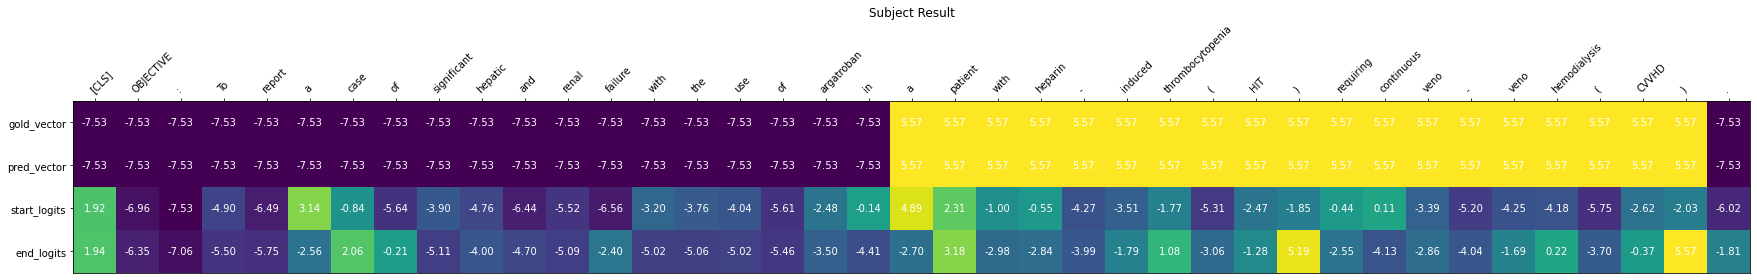

In [50]:
draw('Subject', vis_data)

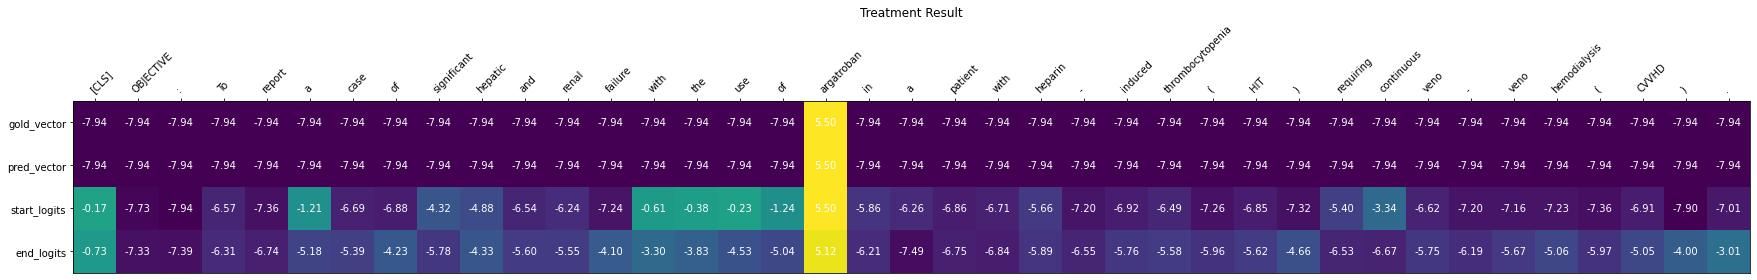

In [51]:
# print("Input Sentence (%s): \n%s"%(sample_info['event_type'], sample_info['sentence']))
draw('Treatment', vis_data)

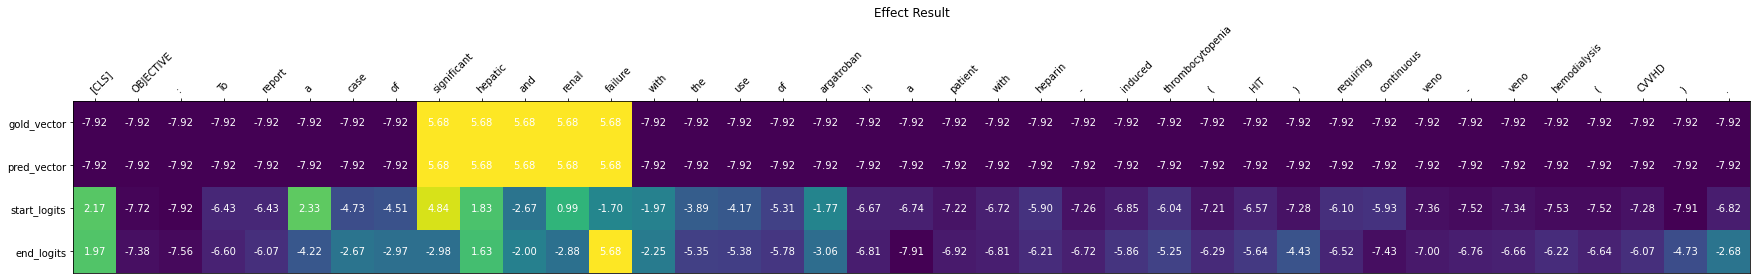

In [52]:
# print("Input Sentence (%s): \n%s"%(sample_info['event_type'], sample_info['sentence']))
draw('Effect', vis_data)